<a href="https://colab.research.google.com/github/UMB200/pytorch_projects/blob/main/Copy_of_08_pytorch_paper_replicating_exercises_solution_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### 1.0 Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
from pathlib import Path

from torch import nn
from torchvision import transforms
from PIL import Image
import pandas as pd

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 2.0 Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### 3.0 Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cab39377b90>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

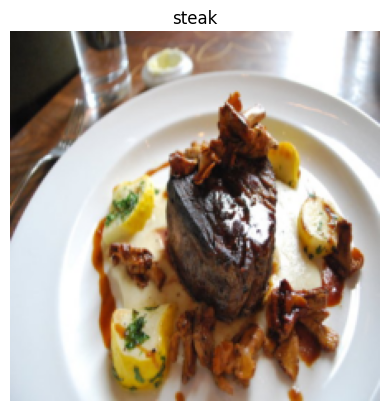

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 4.0 Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

### 4.1 PatchEmbedding Layer

In [ ]:
# Params to use later
PATCH_SIZE = 16
EMBEDDING_DIM = 768
NUMBER_OF_HEADS = 12
MLP_SIZE = 3072

In [ ]:
# Replicating patch embedding step of ViT
# 10/6/25 create a class ti support ViT

class ViTPatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=2,
               patch_size:int=PATCH_SIZE,
               embedding_dimension:int=EMBEDDING_DIM):
    super().__init__()

    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels,
                               out_channels=embedding_dimension,
                               kernel_size=patch_size,
                               stride=patch_size,
                               padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    img_resolution = x.shape[-1]
    assert img_resolution % PATCH_SIZE == 0, f"image resolution ({img_resolution}) must be divisible by patch size ({PATCH_SIZE})"
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)

### 4.2 TransformerEncoderLayer

In [ ]:
transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model = EMBEDDING_DIM,
    nhead = NUMBER_OF_HEADS,
    dim_feedforward = MLP_SIZE,
    dropout = 0.1,
    activation = "gelu",
    batch_first = True,
    norm_first = True)

### 4.3 Build full Transformer Encoder by stacking TransformerEncoderLayers on top of each other

In [ ]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer = transformer_encoder_layer,
    num_layers = NUMBER_OF_HEADS)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


### 4.4 Combine all and build ViT

In [ ]:
# 10/6/25 create a class and initate values
class ViT_arch_class(nn.Module):
  def __init__(self,
               img_size:int=IMG_SIZE,
               patch_size: int=PATCH_SIZE,
               number_transform_layers:int=NUMBER_OF_HEADS,
               embedding_dim:int=EMBEDDING_DIM,
               mlp_size:int=MLP_SIZE,
               number_heads:int=NUMBER_OF_HEADS,
               num_channels:int = 3,
               dropout:float=0.1,
               num_classes:int=1000):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}"

    num_patch = (img_size * img_size) // patch_size**2

    # 1 patch embedding
    self.patch_embedding = ViTPatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dimension=embedding_dim)
    #2 class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)

    #3. positional embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, num_patch+1, embedding_dim), requires_grad=True)

    #4. patch + position embedding dropout
    self.emb_dropout = nn.Dropout(p=dropout)

    #5. Transformer Encoder Layers
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(
        d_model = EMBEDDING_DIM,
        nhead = NUMBER_OF_HEADS,
        dim_feedforward = MLP_SIZE,
        activation = "gelu",
        batch_first = True,
        norm_first = True),
        num_layers = number_transform_layers)

     #7 MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes))

  def forward(self, x):
    batch_size = x.shape[0]
    x = self.patch_embedding(x)
    class_token = self.class_token.expand(batch_size, -1, -1)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.emb_dropout(x)
    x = self.transformer_encoder(x)
    x = self.mlp_head(x[:, 0])
    return x

## 5.0 Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [ ]:
%%writefile vit.py
import torch
from torch import nn

# Params to use later
IMG_SIZE = 224
PATCH_SIZE = 16
EMBEDDING_DIM = 768
NUMBER_OF_HEADS = 12
MLP_SIZE = 3072

class ViTPatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=2,
               patch_size:int=PATCH_SIZE,
               embedding_dimension:int=EMBEDDING_DIM):
    super().__init__()

    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels,
                               out_channels=embedding_dimension,
                               kernel_size=patch_size,
                               stride=patch_size, # Add stride to match kernel_size
                               padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    img_resolution = x.shape[-1]
    assert img_resolution % PATCH_SIZE == 0, f"image resolution ({img_resolution}) must be divisible by patch size ({PATCH_SIZE})"
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)

class ViT_arch_class(nn.Module):
  def __init__(self,
               img_size:int=IMG_SIZE,
               patch_size: int=PATCH_SIZE,
               number_transform_layers:int=NUMBER_OF_HEADS,
               embedding_dim:int=EMBEDDING_DIM,
               mlp_size:int=MLP_SIZE,
               number_heads:int=NUMBER_OF_HEADS,
               num_channels:int = 3,
               dropout:float=0.1,
               num_classes:int=1000):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}"

    # Correct the number of patches calculation
    num_patch = (img_size // patch_size) * (img_size // patch_size)

    # 1 patch embedding
    self.patch_embedding = ViTPatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dimension=embedding_dim)
    #2 class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)

    #3. positional embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, num_patch+1, embedding_dim), requires_grad=True)

    #4. patch + position embedding dropout
    self.emb_dropout = nn.Dropout(p=dropout)

    #5. Transformer Encoder Layers
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(
        d_model = EMBEDDING_DIM,
        nhead = NUMBER_OF_HEADS,
        dim_feedforward = MLP_SIZE,
        activation = "gelu",
        batch_first = True,
        norm_first = True),
        num_layers = number_transform_layers)

     #7 MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes))

  def forward(self, x):
    batch_size = x.shape[0]
    x = self.patch_embedding(x)
    class_token = self.class_token.expand(batch_size, -1, -1)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.emb_dropout(x)
    x = self.transformer_encoder(x)
    x = self.mlp_head(x[:, 0])
    return x

Overwriting vit.py


In [ ]:
!python vit.py

In [ ]:
from vit import ViT_arch_class

imported_vit = ViT_arch_class()
summary(model=imported_vit, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT_arch_class                                [1, 1000]                 152,064
├─ViTPatchEmbedding: 1-1                      [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 6.0 Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [ ]:
# 10/7/25
vit_pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_pretrained_model = torchvision.models.vit_b_16(weights=vit_pretrained_weights).to(device)

for param in vit_pretrained_model.parameters():
  param.requires_grad = False

vit_pretrained_model.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=EMBEDDING_DIM),
    nn.Linear(in_features=EMBEDDING_DIM, out_features=len(class_names))
).to(device)

In [ ]:
data_20_percent = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [ ]:
train_dir_20_percent = data_20_percent / "train"


In [ ]:
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=vit_pretrained_weights.transforms(),
    batch_size=BATCH_SIZE
)

In [ ]:
optimizer = torch.optim.Adam(
    params=vit_pretrained_model.parameters(),
    lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
vit_pretrained_model_results = engine.train(
    model=vit_pretrained_model,
    train_dataloader=train_dataloader_20_percent,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4295 | train_acc: 0.8688 | test_loss: 0.3044 | test_acc: 0.8267
Epoch: 2 | train_loss: 0.1496 | train_acc: 0.9521 | test_loss: 0.2045 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.1078 | train_acc: 0.9688 | test_loss: 0.2003 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.0811 | train_acc: 0.9708 | test_loss: 0.2121 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.0635 | train_acc: 0.9833 | test_loss: 0.2088 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.0495 | train_acc: 0.9938 | test_loss: 0.2069 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0399 | train_acc: 0.9958 | test_loss: 0.2146 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.0388 | train_acc: 0.9958 | test_loss: 0.2126 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.0286 | train_acc: 1.0000 | test_loss: 0.2190 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.0246 | train_acc: 1.0000 | test_loss: 0.2196 | test_acc: 0.9176


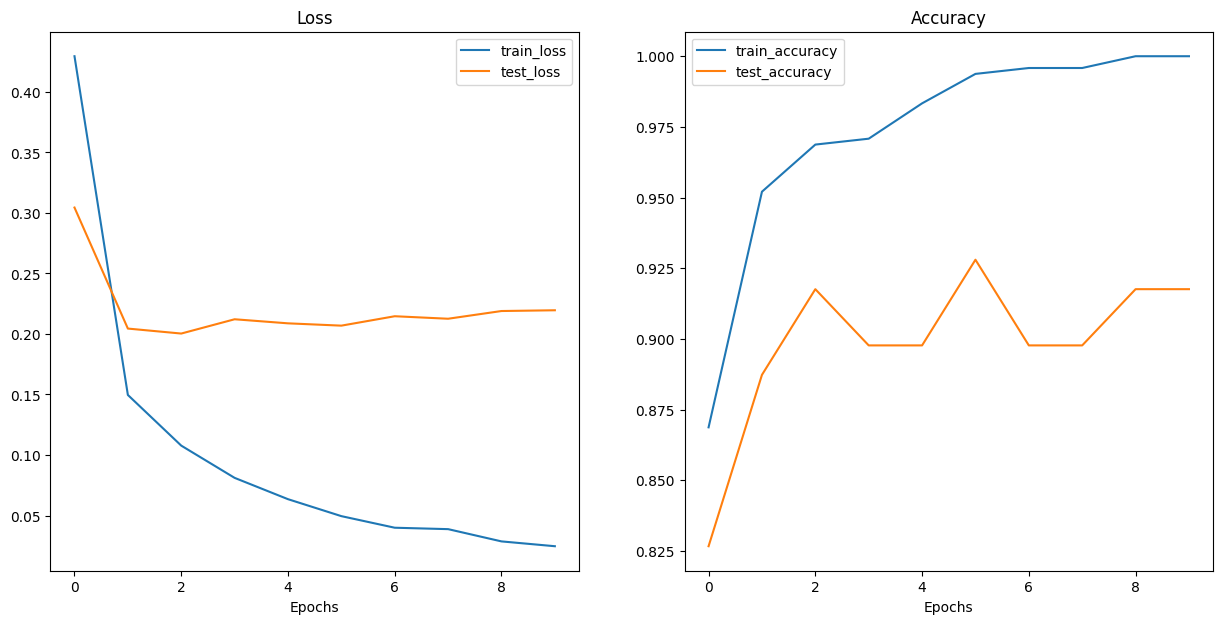

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_pretrained_model_results)

## 7.0 Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [ ]:
# 10/7/25
vit_pretrained_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
vit_pretrained_model_swag = torchvision.models.vit_b_16(weights=vit_pretrained_weights_swag)

for param in vit_pretrained_model_swag.parameters():
  param.requires_grad = False

vit_pretrained_model_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=EMBEDDING_DIM),
    nn.Linear(in_features=EMBEDDING_DIM, out_features=len(class_names))
)

adjusted_transforms = vit_pretrained_weights_swag.transforms()



In [ ]:
summary(model=vit_pretrained_model_swag, input_size=(1, 3, 384, 384),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384] [1, 3]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384] [1, 768, 24, 24] (590,592)       False
├─Encoder (encoder)                                          [1, 577, 768]   [1, 577, 768]   443,136         False
│    └─Dropout (dropout)                                     [1, 577, 768]   [1, 577, 768]   --              --
│    └─Sequential (layers)                                   [1, 577, 768]   [1, 577, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]   [1, 577, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]   [1, 577, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 577, 768]

In [ ]:
data_20_percent = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                destination="pizza_steak_sushi_20_percent")
train_dir_20_percent = data_20_percent / "train"

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [ ]:
train_dataloader_20_percent_img384, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=adjusted_transforms,
    batch_size=BATCH_SIZE
)

In [ ]:
optimizer = torch.optim.Adam(
    params=vit_pretrained_model_swag.parameters(),
    lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# 10/7/25
vit_pretrained_model_results_swag = engine.train(
    model=vit_pretrained_model_swag,
    train_dataloader=train_dataloader_20_percent_img384,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3682 | train_acc: 0.8875 | test_loss: 0.0917 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.0633 | train_acc: 0.9875 | test_loss: 0.0486 | test_acc: 0.9792
Epoch: 3 | train_loss: 0.0393 | train_acc: 0.9917 | test_loss: 0.0462 | test_acc: 0.9792
Epoch: 4 | train_loss: 0.0400 | train_acc: 0.9958 | test_loss: 0.0400 | test_acc: 0.9792
Epoch: 5 | train_loss: 0.0265 | train_acc: 0.9958 | test_loss: 0.0481 | test_acc: 0.9896


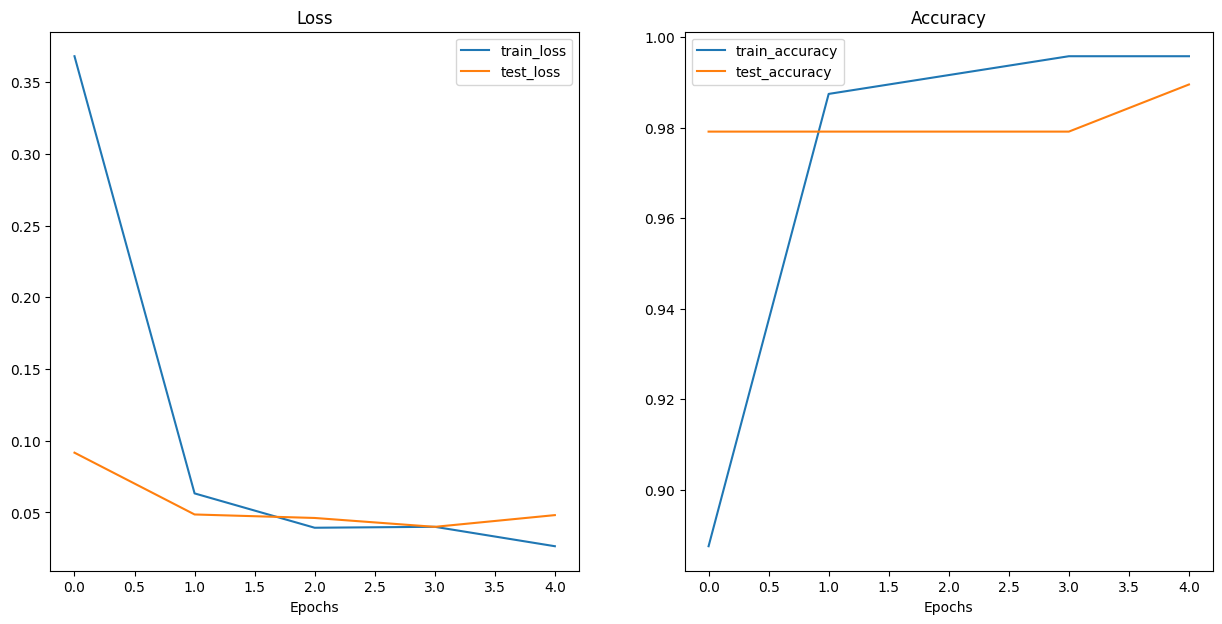

In [ ]:
plot_loss_curves(vit_pretrained_model_results_swag)

## 8.0 Check which image was wrong from exercise 7.0

In [ ]:
# Get test data paths
test_data_paths = list(test_dir.glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Returns a list of dictionaries with sample, label, prediction and prediction probabilities
def get_pred_dicts(model: torch.nn.Module,
                   test_path: list,
                   device: torch.device,
                   class_names: list,
                   transform):
  test_pred_list = []
  for path in tqdm(test_path):
    pred_dict = {}
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name
    img = Image.open(path)
    transformed_img = transform(img).unsqueeze(dim=0)
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_img.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]
      pred_dict["pred_prob"] = pred_prob.unsqueeze(dim=0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    pred_dict["correct"] = class_name == pred_class
    test_pred_list.append(pred_dict)
  return test_pred_list

In [ ]:
test_pred_list = get_pred_dicts(model=vit_pretrained_model_swag,
                                test_path=test_data_paths,
                                device=device,
                                class_names=class_names,
                                transform=adjusted_transforms)
test_pred_list[:3]

100%|██████████| 75/75 [00:03<00:00, 21.94it/s]


[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9988883137702942,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9679439663887024,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9996585845947266,
  'pred_class': 'steak',
  'correct': True}]

In [ ]:
test_pred_data_frame = pd.DataFrame(test_pred_list)
top_3_wrong_preds = test_pred_data_frame.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_3_wrong_preds

,image_path,class_name,pred_prob,pred_class,correct
42,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.726230,steak,False
28,data/pizza_steak_sushi/test/pizza/2111981.jpg,pizza,0.999929,pizza,True
21,data/pizza_steak_sushi/test/pizza/714866.jpg,pizza,0.999894,pizza,True
25,data/pizza_steak_sushi/test/pizza/2236338.jpg,pizza,0.999865,pizza,True
15,data/pizza_steak_sushi/test/steak/3424937.jpg,steak,0.999854,steak,True


/tmp/ipython-input-3199851433.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = r[0]
/tmp/ipython-input-3199851433.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_lbl = r[1]
/tmp/ipython-input-3199851433.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = r[2]
/tmp/ipython-input-3199851433.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, intege

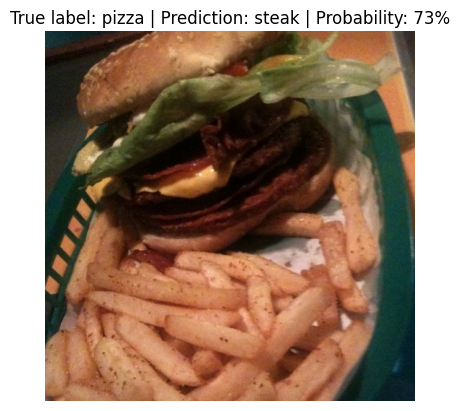

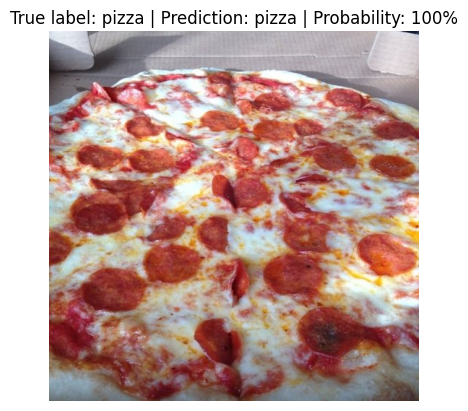

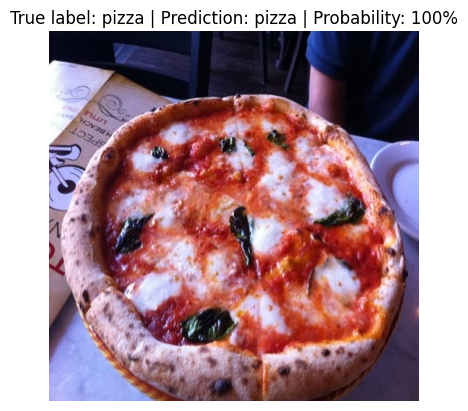

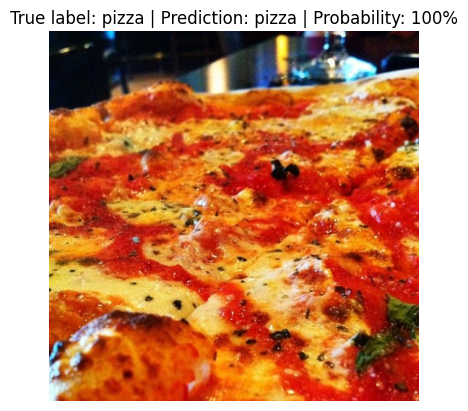

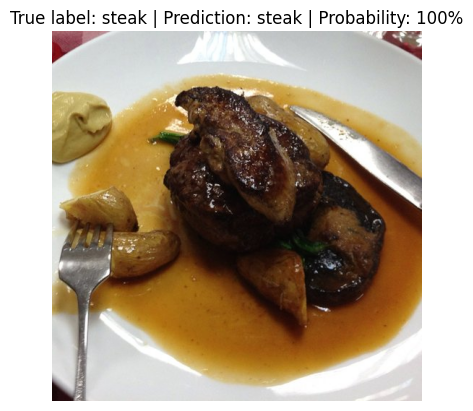

In [ ]:
# 10/9/2025
# show images of too 5 topr wrong predictions
for r in top_3_wrong_preds.iterrows():
  r = r[1]
  image_path = r[0]
  true_lbl = r[1]
  pred_prob = r[2]
  pred_class = r[3]
  img = torchvision.io.read_image(str(image_path))
  plt.figure()
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"True label: {true_lbl} | Prediction: {pred_class} | Probability: {pred_prob:.0%}")
  plt.axis(False)

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

* ImageNet-21k pretraining - comprehensive dataset used for computer vision pretraining. It is organized hierarchically in a tree format: e.g. "pizza" comes from "food" family
One of the locations for this dataset:
https://github.com/Alibaba-MIIL/ImageNet21K

* Learning rate warmup - LR increase depending on the training pace. Starts slowly and gradually increases to a pre-set target LR over as et of steps or epochs

* Learning rate decay - LR decreases during training, when start training LR is higher and along with the training progress LR decreases allowing for finer adjustements  

* Gradient clipping - process that helps maintain numerical stability by preventing the gradients from growing too large. When training NN, the loss gradients are computed through backpropagation. However, if these gradient become too large, the updates to the model weights can also become excessively large, resulting to numerical instability or gradient exploding.